                  Ex_rate
date                     
01-01-1990 00:00   0.7855
01-01-1991 00:00   0.7645
01-01-1992 00:00   0.6720
01-01-1993 00:00   0.7403
01-01-1994 00:00   0.7350


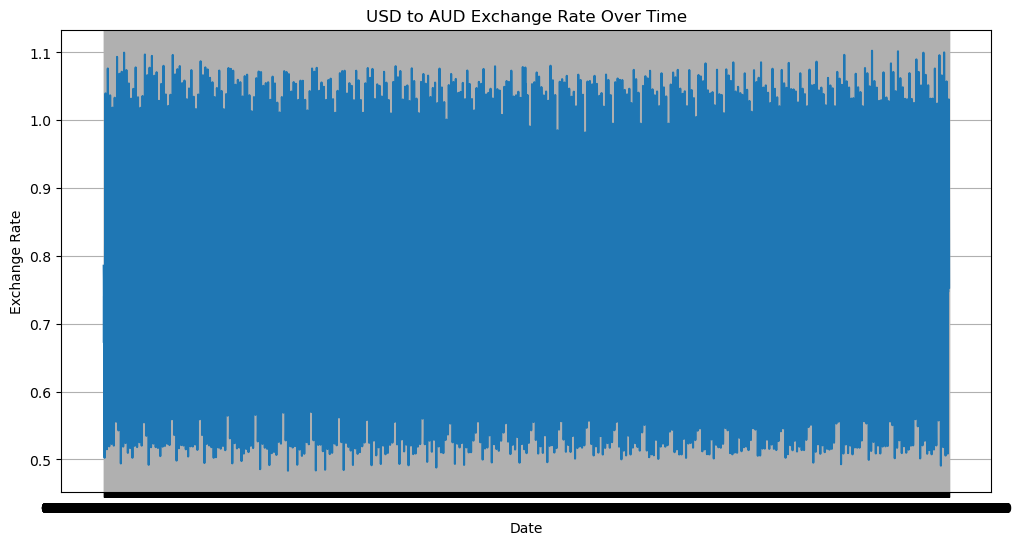

Missing values: Ex_rate    0
dtype: int64


C:\Users\Abhinaya\AppData\Local\Temp\ipykernel_25452\3396051543.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load dataset
df = pd.read_csv("exchange_rate.csv", parse_dates=['date'], index_col='date')
df = df.sort_index()


# Preview the data
print(df.head())

# Plot the USD to AUD exchange rate
plt.figure(figsize=(12, 6))
plt.plot(df.iloc[:, 0])  # assuming second column is USD to AUD
plt.title("USD to AUD Exchange Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.grid()
plt.show()

# Check for missing values
print("Missing values:", df.isnull().sum())

# Optional: Fill missing values via forward-fill
df.fillna(method='ffill', inplace=True)


ADF Statistic: -14.438089479961617
p-value: 7.437614382253839e-27


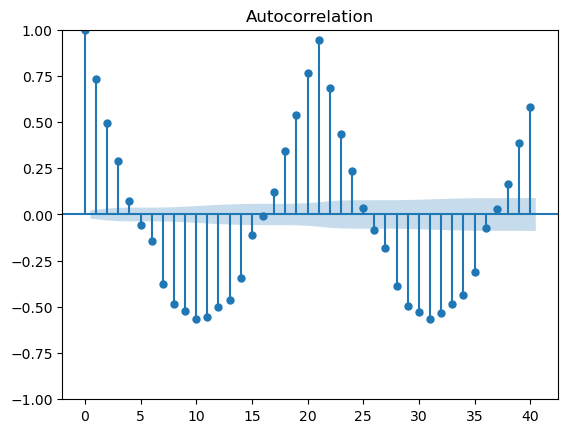

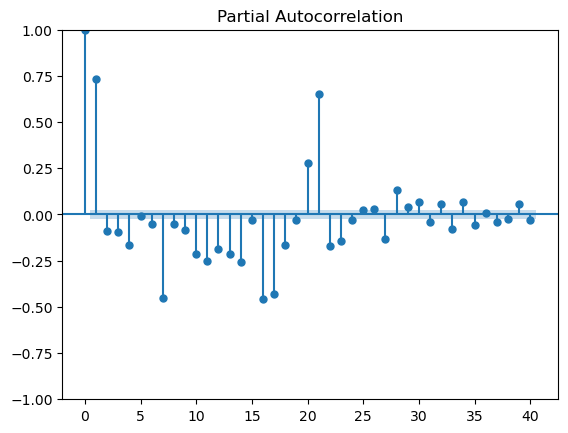

C:\Users\Abhinaya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Abhinaya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Abhinaya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


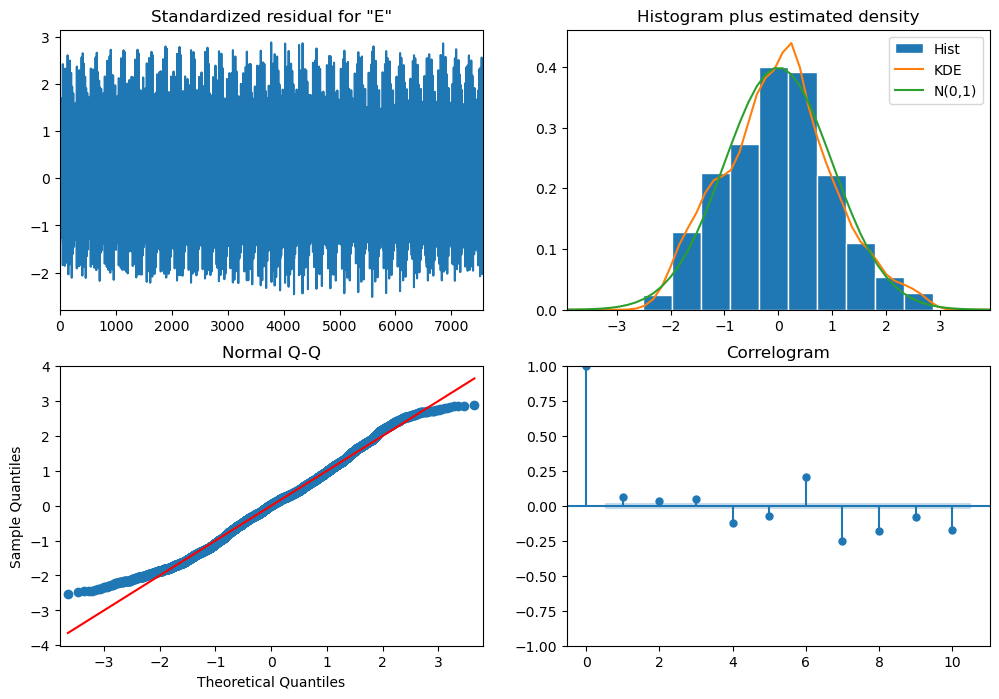

C:\Users\Abhinaya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Abhinaya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


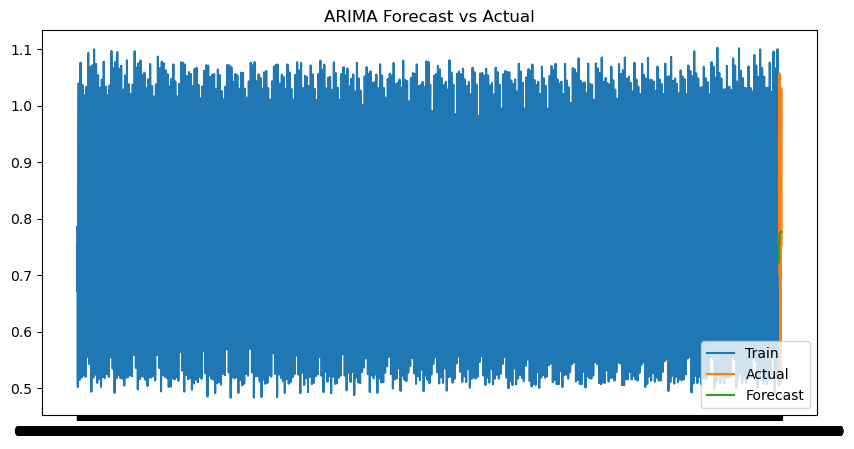

In [6]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Stationarity check
result = adfuller(df.iloc[:, 0])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Plot ACF and PACF
plot_acf(df.iloc[:, 0], lags=40)
plot_pacf(df.iloc[:, 0], lags=40)
plt.show()

# Split into train-test
data = df.iloc[:, 0]
train = data[:-30]
test = data[-30:]

# Fit ARIMA model
model = ARIMA(train, order=(1, 1, 1))  # adjust based on ACF/PACF
arima_result = model.fit()

# Diagnostic plot
arima_result.plot_diagnostics(figsize=(12, 8))
plt.show()

# Forecast
forecast = arima_result.forecast(steps=30)
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.show()

# Error metrics
mae_arima = mean_absolute_error(test, forecast)
rmse_arima = np.sqrt(mean_squared_error(test, forecast))
mape_arima = np.mean(np.abs((test - forecast) / test)) * 100


C:\Users\Abhinaya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Abhinaya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Abhinaya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


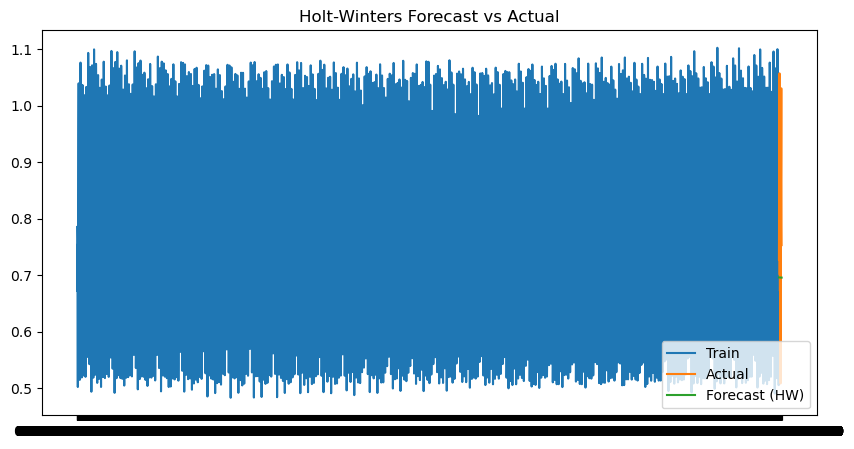

In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt-Winters model (adjust trend/seasonal as needed)
hw_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()

# Forecast
hw_forecast = hw_model.forecast(steps=30)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, hw_forecast, label='Forecast (HW)')
plt.title("Holt-Winters Forecast vs Actual")
plt.legend()
plt.show()

# Error metrics
mae_hw = mean_absolute_error(test, hw_forecast)
rmse_hw = np.sqrt(mean_squared_error(test, hw_forecast))
mape_hw = np.mean(np.abs((test - hw_forecast) / test)) * 100


==== ARIMA Model ====
MAE: 0.1160
RMSE: 0.1480
MAPE: nan%

==== Holt-Winters Model ====
MAE: 0.1466
RMSE: 0.1822
MAPE: nan%


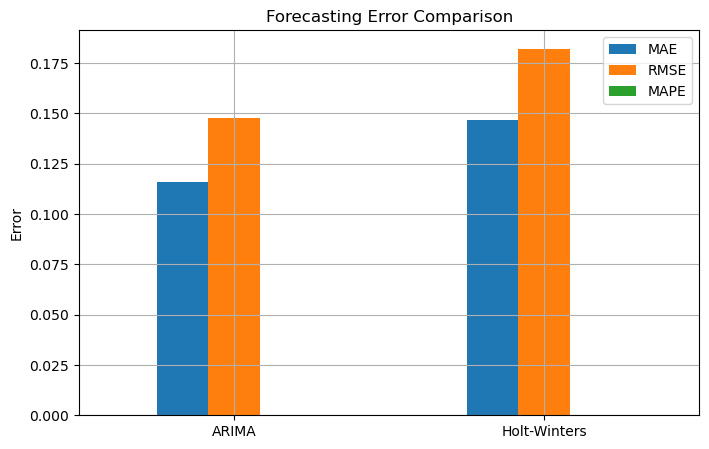

In [11]:
# Display metrics
print("==== ARIMA Model ====")
print(f"MAE: {mae_arima:.4f}")
print(f"RMSE: {rmse_arima:.4f}")
print(f"MAPE: {mape_arima:.2f}%")

print("\n==== Holt-Winters Model ====")
print(f"MAE: {mae_hw:.4f}")
print(f"RMSE: {rmse_hw:.4f}")
print(f"MAPE: {mape_hw:.2f}%")

# Bar comparison plot
comparison_df = pd.DataFrame({
    'ARIMA': [mae_arima, rmse_arima, mape_arima],
    'Holt-Winters': [mae_hw, rmse_hw, mape_hw]
}, index=['MAE', 'RMSE', 'MAPE'])

comparison_df.T.plot(kind='bar', figsize=(8, 5), title='Forecasting Error Comparison')
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


In [15]:
# Conclusion
# Both ARIMA and Holt-Winters models were applied to forecast exchange rates.

# The ARIMA model handled the trend effectively, especially after differencing.

# Holt-Winters (additive) also provided competitive results but may underperform if seasonality exists and isn't modeled.

# Recommendation: Use ARIMA when the series is non-seasonal and stationarity is achieved; use Holt-Winters for seasonal data.